# 1. Import modules

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# 2. Read silver spot and futures data

In [2]:
# Read the silver futures and spot the CSV file
data = pd.read_csv('Silver_SLV_SI_F_Dec_18_Feb_20.csv',index_col='Date')
data.index = pd.to_datetime(data.index)
data = data.dropna()
data.head()

,SI=F,SLV,Silver
Date,,,
2019-01-18,15.330,14.37,15.345
2019-01-22,15.259,14.39,15.335
2019-01-23,15.317,14.42,15.354
2019-01-24,15.238,14.36,15.318
2019-01-25,15.639,14.74,15.747


In [3]:
data.columns = ['near_future','ETF','spot']
data.tail()

,near_future,ETF,spot
Date,,,
2020-02-24,18.868000,17.400000,18.642
2020-02-25,18.183001,16.709999,18.011
2020-02-26,17.826000,16.680000,17.907
2020-02-27,17.799999,16.469999,17.722
2020-02-28,17.658001,15.530000,16.687


# 3. Plot spot, ETF and near-term futures data

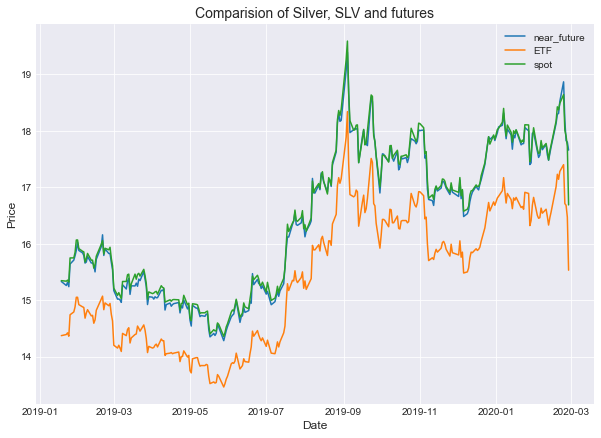

In [4]:
# Set a figure size
plt.figure(figsize=(10, 7))

# Define the label for the title of the figure
plt.title("Comparision of Silver, SLV and futures", fontsize=14)

# Define the labels for x-axis and y-axis
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.plot(data)
plt.legend(data.columns)
plt.show()

# 4. Calculate the position

In [5]:
df_returns = data.pct_change()

# Calculate the roll returns
df_returns['roll'] = df_returns['near_future'] - df_returns['ETF']

# If the futures:spot ratio is greater than 1, you go short on the futures, and long on spot 
# This is done by setting the position to -1
df_returns['position'] = np.where(
    (data.near_future/data.spot > 1), -1, np.nan)

# If the futures:spot ratio is less than the 1, you go long on the futures, and short on spot
# This is done by setting the position to 1
df_returns['position'] = np.where(
    (data.near_future/data.spot < 1), +1, df_returns.position)

df_returns.fillna(method='ffill',inplace=True)

# 5. Plot the positions taken based on the term structure

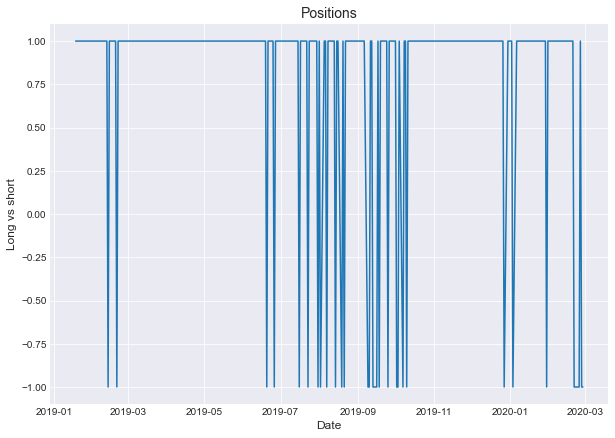

In [6]:
# Set a figure size
plt.figure(figsize=(10, 7))

# Define the label for the title of the figure
plt.title("Positions", fontsize=14)

# Define the labels for x-axis and y-axis
plt.xlabel("Date", fontsize=12)
plt.ylabel("Long vs short", fontsize=12)

plt.plot(df_returns.position)
plt.show()

# 6. Evaluate the strategy

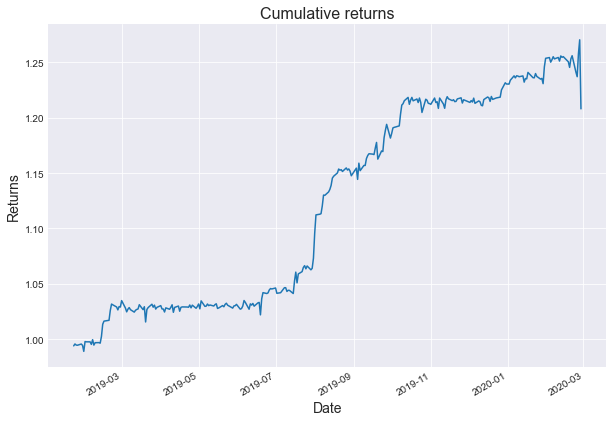

In [7]:
df_returns['strategy_ret'] = df_returns.position.shift(1) * df_returns.roll

# Calculate the trading cost when you square off the position and calculate the net stock_returns
cost = (1.37*2/5000 * np.abs(df_returns.position.shift(1) - df_returns.position))
df_returns['strategy_ret'] = df_returns['strategy_ret'] - cost

# Set a figure size
plt.figure(figsize=(10, 7))
(df_returns['strategy_ret']+1).cumprod().plot()

# Define the label for the title of the figure
plt.title("Cumulative returns", fontsize=16)
# Define the labels for x-axis and y-axis
plt.xlabel("Date", fontsize=14)
plt.ylabel("Returns", fontsize=14)
plt.show()

In [8]:
cum_rets = (df_returns['strategy_ret']+1).cumprod()

# Total number of trading days
days = len(cum_rets)

# Calculate the compounded annual growth rate
cagr = (cum_rets.iloc[-1]**(252/days)-1)*100

print('The CAGR from strategy is')
cagr

The CAGR from strategy is


18.763749352585247

The maximum drawdown is -4.91


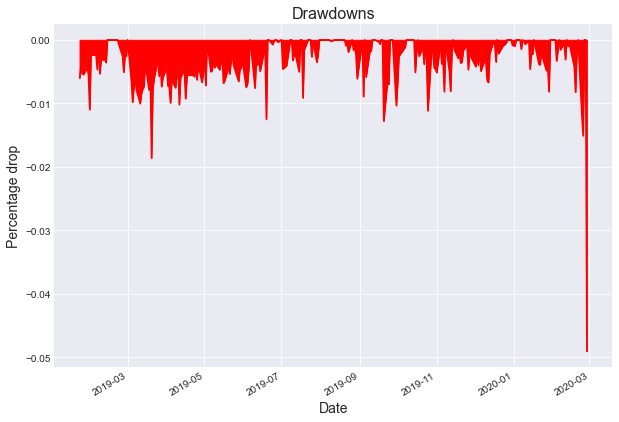

In [9]:
running_max = np.maximum.accumulate(cum_rets.dropna())
# Ensure the value never drops below 1
running_max[running_max < 1] = 1
# Calculate the percentage drawdown
drawdown = ((cum_rets)/running_max - 1)

max_dd = drawdown.min()*100
print('The maximum drawdown is %.2f' % max_dd)
  
# Set a figure size
plt.figure(figsize=(10, 7))
# Define the label for the title of the figure
plt.title("Drawdowns", fontsize=16)
# Define the labels for x-axis and y-axis
plt.xlabel("Date", fontsize=14)
plt.ylabel("Percentage drop", fontsize=14)

plt.fill_between(drawdown.index, drawdown, color='red')
drawdown.plot(color='r') 
plt.show()